# Compare 2 Surf En

In [ ]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from calculations import triangular as tri
from manage import utils

sns.set_theme()

###

data_dirs = [
    "/home/max/projects/apfc/data/01n0VBeta/beta/1.270000",
    "/home/max/projects/apfc/data/01n0VBeta/beta/1.465000"
]

surf_en_indeces = [-1, -1]

names = ["neg", "pos"]

colors = ["r", "b"]
line_widths = [2, 1]

normalize = True
norm_min_0 = True

add_lim = [0.1, 0.02]
plot_zero_line = True
apply_lims = True

hide_xticks = True
hide_yticks = True

recalc_fits = False

In [ ]:
def norm(arr, norm_min_0=False):
    if norm_min_0:
        ret = arr - np.min(arr)
    else:
        ret = arr
    return ret / np.max(ret) 

configs = []
thetas = []
thetas_str = []
surf_ens = []
stiffs = []
fits = []

for data_dir in data_dirs:

    ### Config ###

    config_path = f"{data_dir}/config.json"
    with open(config_path, "r") as f:
        config = json.load(f)

    ### Surf En ###

    surf_en = pd.read_csv(f"{data_dir}/evaluate/surf_en.csv", index_col=0)
    surf_en = surf_en.apply(pd.to_numeric)

    ### Thetas ###

    theta_str = surf_en.columns.to_numpy()
    theta = utils.get_thetas(config)

    ### stiffness ###

    stiff = pd.read_csv(f"{data_dir}/evaluate/stiff.csv", index_col=0)
    stiff = stiff.apply(pd.to_numeric)

    ## fits ###

    fit = pd.read_csv(f"{data_dir}/evaluate/fits.csv", index_col=0)
    fit = fit.apply(pd.to_numeric)

    ### Fill ###

    div = config["thetaDiv"]
    theta = utils.fill(theta, div, True)

    ### Appends ###normalize
    
    configs.append(config)
    surf_ens.append(surf_en)
    thetas.append(theta)
    thetas_str.append(theta_str)
    stiffs.append(stiff)
    fits.append(fit)

###

fig = plt.figure()
ax_surf = plt.subplot(121, projection="polar")
ax_stiff = plt.subplot(122, projection="polar")

ax_surf.set_aspect("equal")
ax_stiff.set_aspect("equal")

plot_stiff = []
plot_surf = []

if plot_zero_line:

    # this guarantees that 0 is present even if sur en is negative
    surf_lim = [0., 0.]
    stiff_lim = [0., 0.]

else:
    surf_lim = [1e6, -1e6]
    stiff_lim = [1e6, -1e6]

for i in range(len(surf_ens)):

    surf = surf_ens[i].iloc[surf_en_indeces[i], :].to_numpy()
    stiff = stiffs[i].iloc[surf_en_indeces[i], :].to_numpy()

    if normalize:

        surf = norm(surf, norm_min_0)
        stiff = norm(stiff, norm_min_0)

    plot_stiff.append(stiff)
    plot_surf.append(surf)

for i in range(len(plot_surf)):

    ax_surf.plot(thetas[i], plot_surf[i], c=colors[i], label=names[i], lw=line_widths[i])
    ax_stiff.plot(thetas[i], plot_stiff[i], c=colors[i], label=names[i], lw=line_widths[i])

    surf_lim[0] = np.min([surf_lim[0], np.min(surf)])
    stiff_lim[0] = np.min([stiff_lim[0], np.min(stiff)])

    surf_lim[1] = np.max([surf_lim[1], np.max(surf)])
    stiff_lim[1] = np.max([stiff_lim[1], np.max(stiff)])

    eps = fits[i]["eps"].to_numpy()[surf_en_indeces[i]]
    gamma0 = fits[i]["gamma0"].to_numpy()[surf_en_indeces[i]]

    if recalc_fits:
        try:
            eps, gamma0 = tri.fit_surf_en(thetas[i], plot_surf[i])
        except ValueError as e:
            pass

    print(names[i], f"eps: {eps:.4f}, gamma0: {gamma0:.4f}")
        

surf_lim[1] += add_lim[1]
stiff_lim[1] += add_lim[1]

surf_lim[0] -= add_lim[0]
stiff_lim[0] -= add_lim[0]

if surf_lim[0] < 0 < surf_lim[1] and plot_zero_line:
    ax_surf.plot(thetas[0], np.zeros(thetas[0].shape), c="black", lw=0.5)

if stiff_lim[0] < 0 < stiff_lim[1] and plot_zero_line:
    ax_stiff.plot(thetas[0], np.zeros(thetas[0].shape), c="black", label="$\\gamma=0$", lw=0.5)

ax_surf.set_title("Surface Energy")
ax_stiff.set_title("Stiffness")
ax_stiff.legend(bbox_to_anchor=(1.1, 1.1))

if hide_xticks:
    ax_surf.set_xticklabels([])
    ax_stiff.set_xticklabels([])
if hide_yticks:
    ax_stiff.set_yticklabels([])
    ax_surf.set_yticklabels([])

if apply_lims:
    ax_surf.set_ylim(surf_lim)
    ax_stiff.set_ylim(stiff_lim)

plt.show()

# Plot Volume 1D

In [ ]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from calculations import observables
from manage import utils
from manage import read_write as rw

sns.set_theme()

sim_path = "/home/max/projects/apfc/data/01n0VBx/Bx/0.100000"
plot_i = 8
add_max = 5
use_real_min = False
ignore_eta_index = {}

do_polar_plot = True

use_config_max = True # has higher prio than calc_min_max
calc_min_max = True

hide_x_axis_label = True
hide_y_axis_label = False

In [ ]:
sim_path = utils.make_path_arg_absolute(sim_path)
config = utils.get_config(sim_path)

#################

df_fits = pd.read_csv(f"{sim_path}/evaluate/eval.csv", index_col=(0, 1))
df_radius = df_fits.iloc[df_fits.index.get_level_values(1) == "radius"]

thetas = df_radius.columns.astype(float)

In [ ]:
fig = plt.figure()

if do_polar_plot:
    ax = plt.subplot(111, projection="polar")
    ax.set_aspect("equal")
    if hide_x_axis_label:
        ax.set_xticklabels([])
    if hide_y_axis_label:
        ax.set_yticklabels([])
else:
    ax = plt.subplot(111)

max_val = 0.
min_val = 1e10

radius_row = df_radius.iloc[plot_i]

max_val = np.max([max_val, np.max(radius_row)])
min_val = np.min([min_val, np.min(radius_row)])

ax.plot(thetas, radius_row)

if use_config_max:
    ax.set_ylim([0, config["xlim"]])
elif calc_min_max:
    ax.set_ylim([min_val if use_real_min else 0, max_val + add_max])

plt.show()

# Reconstruct 2D from 1D theta sims

In [ ]:
%config InlineBackend.figure_formats = ['png']
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from manage import utils
from manage import read_write as rw

sns.set_theme()

sim_path = "/home/max/projects/apfc/data/05n0"
plot_i = -1

pt_size = 1

In [ ]:
sim_path = utils.make_path_arg_absolute(sim_path)
config = utils.get_config(sim_path)

eta_count = len(config["G"])
line_count = rw.count_lines(f"{sim_path}/eta_files/0.0000/out_0.txt")

thetas = utils.get_thetas(config)
thetas_str = [f"{theta:.4f}" for theta in thetas]

x_full = np.linspace(-config["xlim"], config["xlim"], config["numPtsX"])
x, _ = utils.get_positive_range(x_full, np.zeros(x_full.shape))
y = np.zeros(x.shape)
xy = np.array([x, y])

if plot_i < 0:
    plot_i = line_count - np.abs(plot_i)

fig = plt.figure()
ax = plt.subplot(111)
ax.set_aspect("equal")

for div_i in range(config["thetaDiv"]):
    for theta_i, theta in enumerate(thetas):

        # this condition is to avoid double printing of the bounds
        if theta_i == thetas.shape[0] - 1:
            continue

        theta_dir = f"{sim_path}/eta_files/{theta:.4f}"
        etas = rw.read_all_etas_at_line(
            theta_dir, plot_i, config["numPtsX"], config["numPtsY"], eta_count
        )

        theta = theta + div_i * 2. * np.pi / config["thetaDiv"]

        rot = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])

        rot_xy = rot.dot(xy)

        eta_sum = np.zeros(etas[0].shape)
        for eta_i in range(eta_count):
            eta_sum += etas[eta_i]**2

        _, eta_sum = utils.get_positive_range(x_full, eta_sum)

        ax.scatter(rot_xy[0], rot_xy[1], c=eta_sum, s=pt_size)

plt.show()

# Reconstruct 2D from 1D with Tangents

In [ ]:
%config InlineBackend.figure_formats = ['png']
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from manage import utils
from manage import read_write as rw
from calculations import observables

sns.set_theme()

sim_path = "/home/max/projects/apfc/data/06base"
plot_i = -1

pt_size = 0.01

line_plot_color="g"
line_plot_width = 2
line_add_rot = 0.#np.pi/6

alpha = 1

line_angles = np.array([
    i * np.pi/3 for i in range(6)
])

In [ ]:
line_angles += line_add_rot

sim_path = utils.make_path_arg_absolute(sim_path)
config = utils.get_config(sim_path)

eta_count = len(config["G"])
line_count = rw.count_lines(f"{sim_path}/eta_files/0.0000/out_0.txt")

thetas = utils.get_thetas(config)
thetas_str = [f"{theta:.4f}" for theta in thetas]

thetas_angle_is = []
for line_angle in line_angles:
    theta_diff = np.abs(thetas - line_angle)
    theta_i = np.argmin(theta_diff)
    thetas_angle_is.append(theta_i)

x_line = np.linspace(-config["xlim"], config["xlim"], config["numPtsX"])
is_get_0_i = (x_line >= 0).nonzero()
x = x_line[is_get_0_i]
y = np.zeros(x.shape)
xy = np.array([x, y])
dx = np.abs(x[0]-x[1])

# fmt: off
rot_90_deg = np.array([
    [np.cos(np.pi/2), -np.sin(np.pi/2)],
    [np.sin(np.pi/2), np.cos(np.pi/2)]
])
# fmt: on

if plot_i < 0:
    plot_i = line_count - np.abs(plot_i)

fig = plt.figure()
ax = plt.subplot(111)
ax.set_aspect("equal")

for div_i in range(config["thetaDiv"]):
    for theta_i, theta in enumerate(thetas):

        theta_dir = f"{sim_path}/eta_files/{theta:.4f}"
        etas = rw.read_all_etas_at_line(
            theta_dir, plot_i, config["numPtsX"], config["numPtsY"], eta_count
        )

        theta = theta + div_i * 2. * np.pi / config["thetaDiv"]

        rot = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])

        rot_xy = rot.dot(xy)

        eta_sum = np.zeros(etas[0].shape)
        for eta_i in range(eta_count):
            eta_sum += etas[eta_i]**2

        eta_sum = eta_sum[is_get_0_i]

        ax.scatter(rot_xy[0], rot_xy[1], c=eta_sum, s=pt_size, alpha=alpha)

        if theta_i in thetas_angle_is:
            
            r, _ = observables.get_phase_volumes(eta_sum, dx)
            xy_base = np.array([r*np.cos(theta), r*np.sin(theta)])
            xy_line = rot_90_deg.dot(xy_base)

            m = xy_line[1] / xy_line[0]
            n = xy_base[1] - m * xy_base[0]

            print(f"{thetas[theta_i]:.4f}, r={r:.4f}, m={m:.4f}, n={n:.4f}")

            y_line = m * x_line + n
            line_bounds = np.logical_and(
                y_line < config["xlim"],
                y_line > -config["xlim"]
            )

            y_line_plot = y_line[line_bounds]
            x_line_plot = x_line[line_bounds]

            if m > 1e5:

                ax.vlines(
                    xy_base[0], 
                    -config["xlim"], 
                    config["xlim"],
                    color=line_plot_color,
                    lw=line_plot_width
                )

            else:

                ax.plot(
                    x_line_plot, 
                    y_line_plot, 
                    c=line_plot_color, 
                    lw=line_plot_width
                )
            

plt.show()

# Plot Fits for Varying Parameter

In [82]:
%config InlineBackend.figure_formats = ['png']
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

sns.set_theme()
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

from manage import utils

sim_paths = [
    "/home/max/projects/apfc/data/01n0VBx",
    "/home/max/projects/apfc/data/01n0VBeta",
    "/home/max/projects/apfc/data/05n0VBx",
    "/home/max/projects/apfc/data/05n0VBeta",
]
sim_path_i = 0

sim_i = -1

colors = sns.color_palette()

eps_color = colors[0]
gamma0_color = colors[1]

ls = "--"
marker = "o"

remove_out_lier_is = [
    [-3, -2, -1], #[0, 1, -3], # 01n0VBx
    None, # 01n0VBeta
    [0], #[0, 5, 10], # 05n0VBx
    None, # 05n0VBeta
]

x_axis_texts = [
    "$B^x$",
    "$\\beta$",
    "$B^x$",
    "$\\beta$",
]

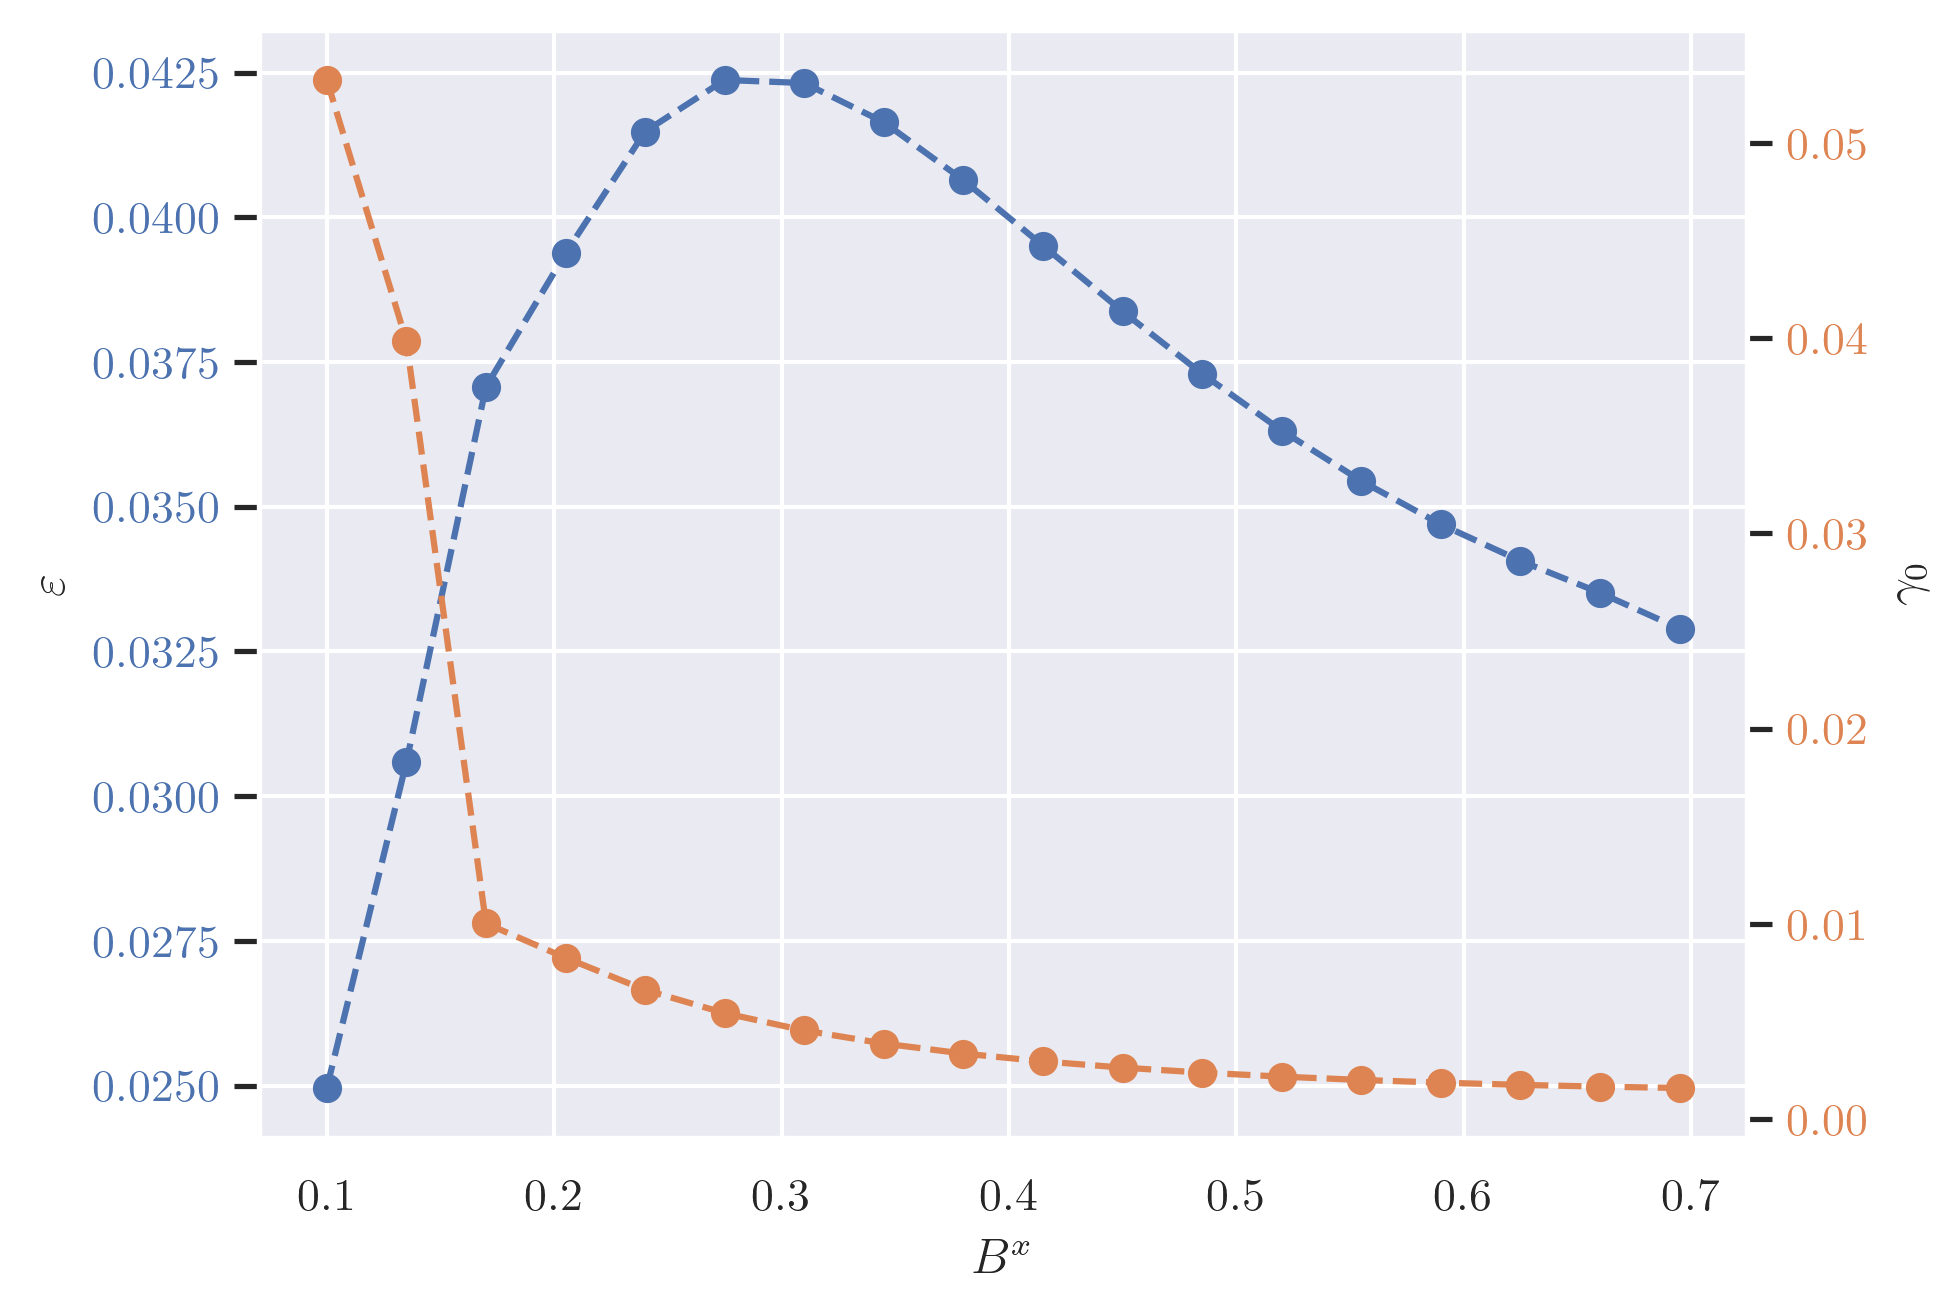

In [83]:
sim_path = sim_paths[sim_path_i]
remove_out_lier_i = remove_out_lier_is[sim_path_i]

sim_path = utils.make_path_arg_absolute(sim_path)
config = utils.get_config(sim_path)

vary_param = config["varyParam"]
vary_dir = f"{sim_path}/{config['varyParam']}"

vary_values = utils.read_vary_vals_from_dir(vary_dir, vary_param)

fit_values = pd.DataFrame(
    columns=["eps", "gamma0"], index=range(vary_values.shape[0])
)

for vary_i, vary_val in enumerate(vary_values):

    vary_sim_dir = f"{vary_dir}/{utils.get_vary_val_dir_name(vary_val)}"
    df_fits = pd.read_csv(f"{vary_sim_dir}/evaluate/fits.csv", index_col=0)

    fit_i = sim_i
    if fit_i < 0:
        fit_i = df_fits.shape[0] - np.abs(fit_i)

    fit_values.loc[vary_i, "eps"] = df_fits.loc[fit_i, "eps"]
    fit_values.loc[vary_i, "gamma0"] = df_fits.loc[fit_i, "gamma0"]

plt_eps =fit_values["eps"].to_numpy()
plt_gamma0 = fit_values["gamma0"].to_numpy()

if remove_out_lier_i is not None:
    vary_values = np.delete(vary_values, remove_out_lier_i)
    plt_eps = np.delete(plt_eps, remove_out_lier_i)
    plt_gamma0 = np.delete(plt_gamma0, remove_out_lier_i)

fig = plt.figure()

ax_eps = plt.subplot(111)
ax_eps.plot(vary_values, plt_eps, color=eps_color, linestyle=ls, marker=marker)
ax_eps.set_ylabel("$\\varepsilon$")
ax_eps.tick_params(axis="y", labelcolor=eps_color)

ax_gamma0 = ax_eps.twinx()
ax_gamma0.plot(vary_values, plt_gamma0, color=gamma0_color, linestyle=ls, marker=marker)
ax_gamma0.set_ylabel("$\\gamma_0$")
ax_gamma0.grid(visible=None)
ax_gamma0.tick_params(axis="y", labelcolor=gamma0_color)

if x_axis_texts[sim_path_i] is None:
    ax_eps.set_xlabel(config["varyParam"])
else:
    ax_eps.set_xlabel(x_axis_texts[sim_path_i])

plt.show()

# Fit params over time

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from manage import utils

sns.set_theme()
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})


sim_path = "/home/max/projects/apfc/data/05base"

starting_index = 1

use_norm_surf_en = False

colors = sns.color_palette()
eps_color = colors[0]
gamma0_color = colors[1]

hide_gamma = False

ls = "--"
marker = "o"

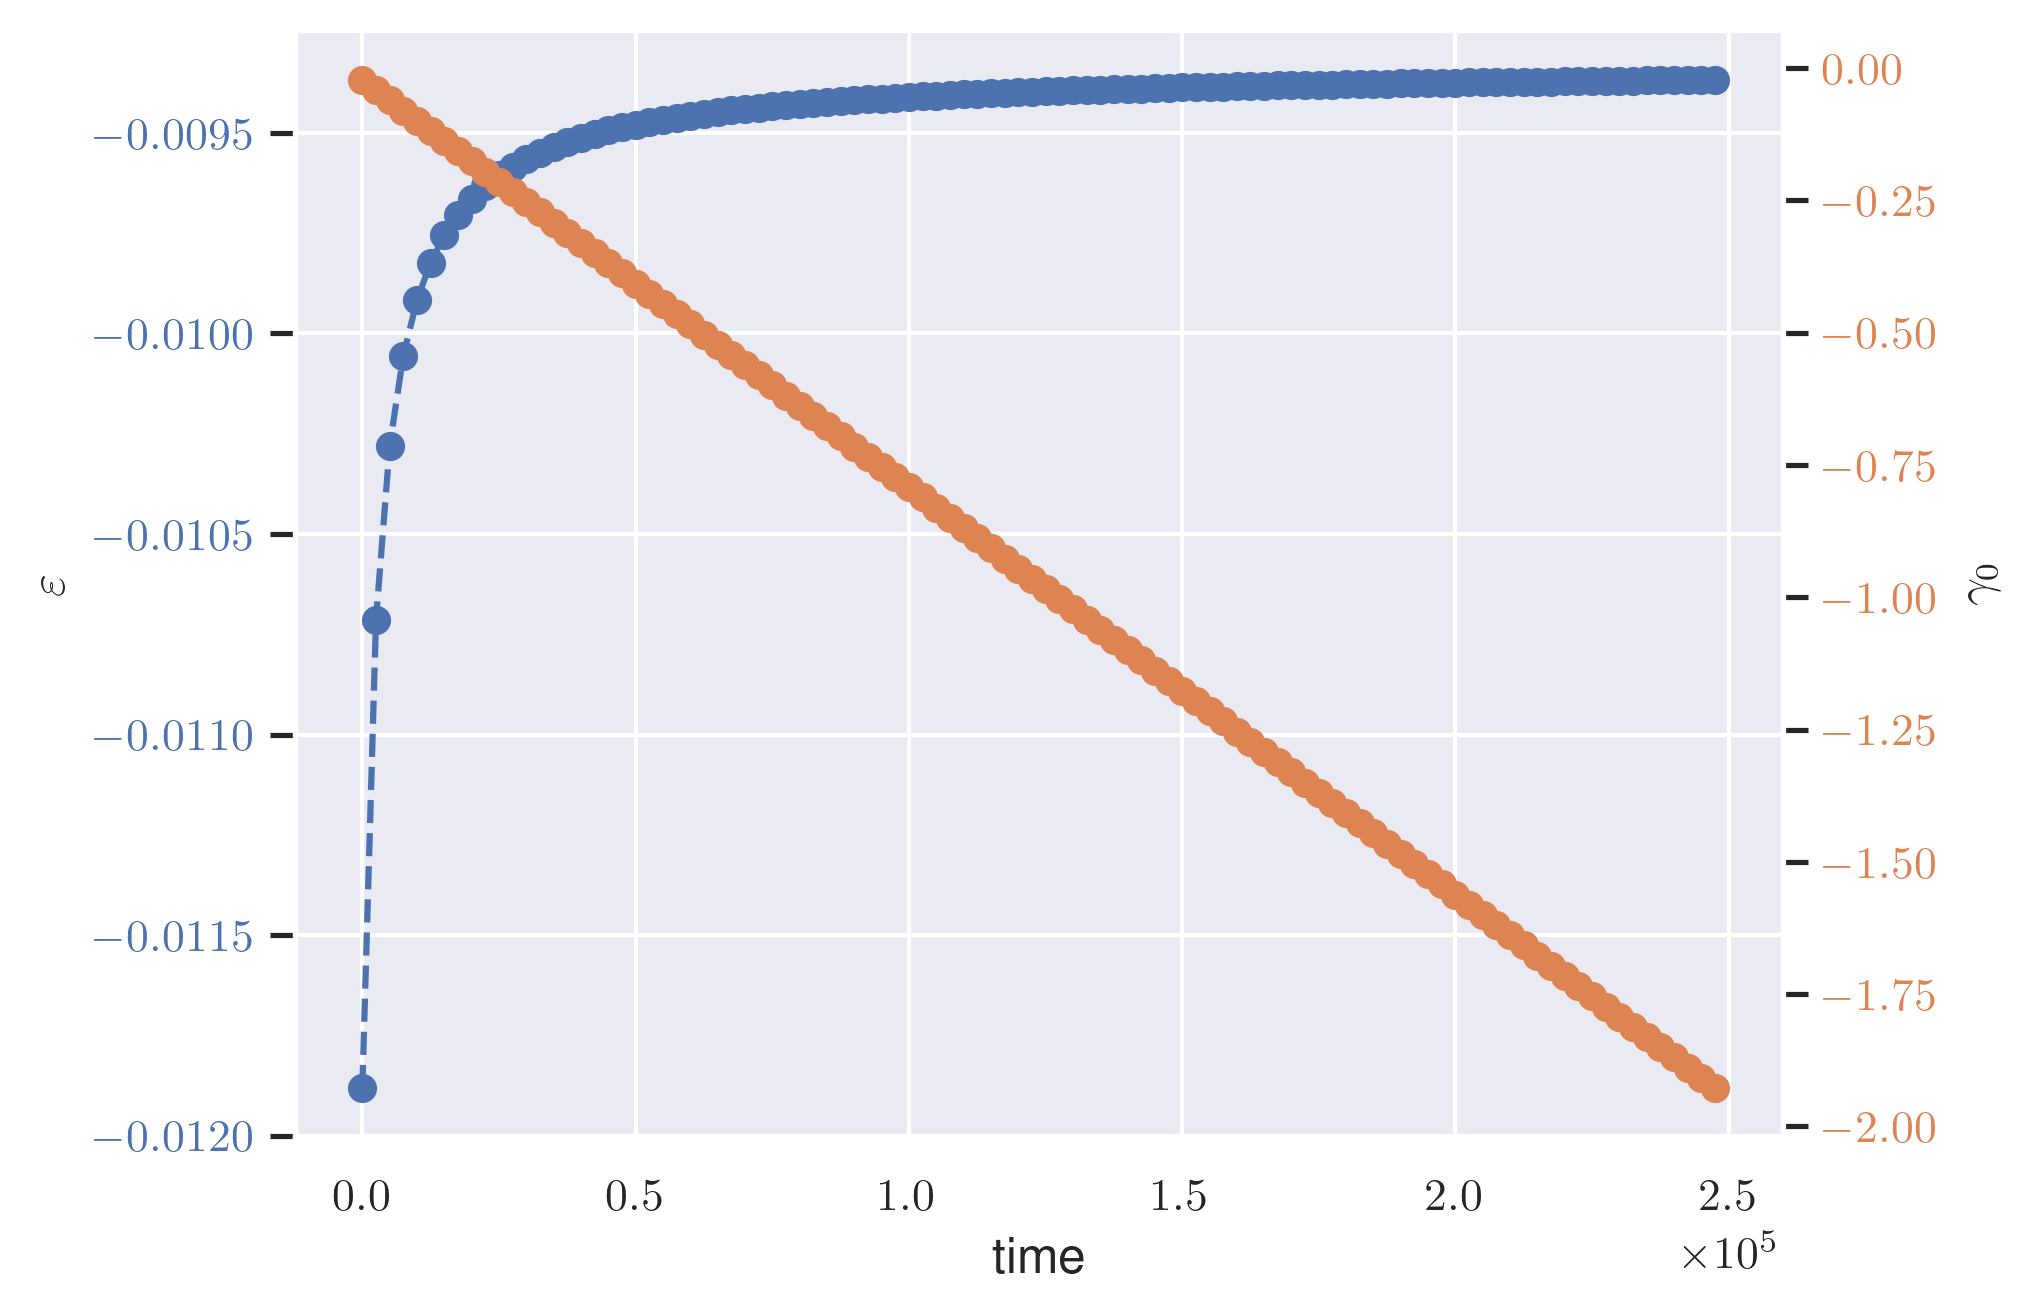

In [102]:
sim_path = utils.make_path_arg_absolute(sim_path)
config = utils.get_config(sim_path)

name_app = "_norm" if use_norm_surf_en else ""

df_fits = pd.read_csv(f"{sim_path}/evaluate/fits{name_app}.csv", index_col=0)
df_fits = df_fits.iloc[starting_index:]
time = np.array(range(df_fits.shape[0])) * config["writeEvery"] * config["dt"]

fig = plt.figure()

ax_eps = plt.subplot(111)
ax_eps.plot(time, df_fits["eps"], color=eps_color, linestyle=ls, marker=marker)
ax_eps.set_ylabel("$\\varepsilon$")
ax_eps.tick_params(axis="y", labelcolor=eps_color)

if not hide_gamma:
    ax_gamma0 = ax_eps.twinx()
    ax_gamma0.plot(time, df_fits["gamma0"], color=gamma0_color, linestyle=ls, marker=marker)
    ax_gamma0.set_ylabel("$\\gamma_0$")
    ax_gamma0.grid(visible=None)
    ax_gamma0.tick_params(axis="y", labelcolor=gamma0_color)

ax_eps.set_xlabel("time")
plt.ticklabel_format(
    axis="x", 
    style="scientific", 
    useMathText=True, 
    useOffset=True, 
    scilimits=(0, 0)
)

plt.show()

In [98]:
import scipy

def log_func(x, a, b, c, d):
    return a * np.log(b * x + c) + d

popt, pcov = scipy.optimize.curve_fit(
    log_func, time, df_fits["eps"]
)

print(popt)
print(pcov)

[1.33500669e-05 1.36390911e+00 1.79105296e+01 7.16149847e-03]
[[ 7.55439612e-13 -1.02903043e-03 -1.35049793e-02  1.00805734e-08]
 [-1.02903043e-03  4.60064243e+08  6.04144427e+09 -4.51050405e+03]
 [-1.35049792e-02  6.04144427e+09  7.93346789e+10 -5.92307690e+04]
 [ 1.00805734e-08 -4.51050405e+03 -5.92307690e+04  4.42213172e-02]]


/tmp/ipykernel_29338/3890647535.py:4: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x + c) + d


# Is in eq?

In [ ]:
import os
import numpy as np
from manage import utils
from manage import read_write as rw
from calculations import observables

#sim_path = "/home/max/projects/apfc/data/01n0VBx"
sim_path = "/home/max/projects/apfc/data/05n0VBx"
#sim_path = "/home/max/projects/apfc/data/01n0VBeta"
sim_i = -1

tolerance = 1e-1
zero_ampl_tolerance = 1e-5

In [ ]:
def has_not_changed(arr, prev_arr, tolerance):
    return np.all(np.isclose(arr, prev_arr, atol=tolerance))


def elems_are_similar(arr, tolerance = 1e-5):
    median = np.average(arr)
    return np.all(np.abs(arr - median) < tolerance)


def has_equal_phases(x, arr, radius, int_width, sim_tolerance=1e-5):

    dx = np.diff(x)[0]

    int_width_index_len = int_width // dx + 1
    radius_index_len = radius // dx + 1

    solid_index_len = int(radius_index_len - int_width_index_len)
    liqid_index_len = int(arr.shape[0] - (radius_index_len + int_width_index_len))

    if liqid_index_len <= 0:
        print("Liquid len is less than 1")

    arr_solid = arr[:solid_index_len]
    arr_liquid = arr[-liqid_index_len:]

    similar_solid = elems_are_similar(arr_solid, sim_tolerance)
    similar_liquid = elems_are_similar(arr_liquid, sim_tolerance)

    return similar_solid and similar_liquid


def is_in_equilibrium(x, arr, prev_arr, radius, int_width, sim_tolerance=1e-5):

    not_changed = has_not_changed(arr, prev_arr, sim_tolerance)
    phase_is_eq = has_equal_phases(x, arr, radius, int_width, sim_tolerance)

    return not_changed and phase_is_eq


def get_eta_info(sim_dir, config, index):

    x_all = np.linspace(
        -config["xlim"],
        config["xlim"],
        config["numPtsX"]
    )
    eta_count = len(config["G"])

    etas = rw.read_all_etas_at_line(
        sim_dir,
        index,
        config["numPtsX"],
        config["numPtsY"],
        eta_count
    )

    eta_sum = np.zeros(etas[0].shape)
    for eta_i in range(eta_count):
        eta_sum += etas[eta_i] * np.conj(etas[eta_i])
    eta_sum = eta_sum.flatten()

    etas_prev = rw.read_all_etas_at_line(
        sim_dir,
        index-1,
        config["numPtsX"],
        config["numPtsY"],
        eta_count
    )

    eta_sum_prev = np.zeros(etas_prev[0].shape)
    for eta_i in range(eta_count):
        eta_sum_prev += etas_prev[eta_i] * np.conj(etas_prev[eta_i])
    eta_sum_prev = eta_sum_prev.flatten()

    x, eta_sum = utils.get_positive_range(x_all, eta_sum)
    _, eta_sum_prev = utils.get_positive_range(x_all, eta_sum_prev)

    radius, int_width = observables.fit_to_tanhmin(x, eta_sum, True)

    return x, eta_sum, eta_sum_prev, radius, int_width


def are_amplitudes_0(sim_dir, config, index, tolerance):

    eta_count = len(config["G"])

    etas = rw.read_all_etas_at_line(
        sim_dir,
        index,
        config["numPtsX"],
        config["numPtsY"],
        eta_count
    )

    eta_sum = np.zeros(etas[0].shape)
    for eta_i in range(eta_count):
        eta_sum += etas[eta_i] * np.conj(etas[eta_i])
    eta_sum = eta_sum.flatten()

    return elems_are_similar(eta_sum, tolerance)


def is_n0_in_eq(sim_dir, config, index, radius, int_width, tolerance):

    x_all = np.linspace(
        -config["xlim"],
        config["xlim"],
        config["numPtsX"]
    )

    n0 = rw.read_arr_at_line(
        f"{sim_dir}/n0.txt",
        index,
        config["numPtsX"],
        config["numPtsY"]
    )
    n0_prev = rw.read_arr_at_line(
        f"{sim_dir}/n0.txt",
        index-1,
        config["numPtsX"],
        config["numPtsY"]
    )

    n0 = n0.flatten()
    n0_prev = n0_prev.flatten()

    x, n0 = utils.get_positive_range(x_all, n0)
    _, n0_prev = utils.get_positive_range(x_all, n0_prev)

    return is_in_equilibrium(x, n0, n0_prev, radius, int_width, tolerance)


def get_theta_non_eqs(theta_dir, index, config, tolerance=1e-5, ampl_tol=1e-5):

    non_eq = []
    all_zero = []
    is_n0 = config["simType"] == "n0"

    all_thetas = os.listdir(theta_dir)
    for theta in all_thetas:

        sim_dir = f"{theta_dir}/{theta}"

        if index < 0:
            row_count = rw.count_lines(f"{sim_dir}/n0.txt")
            index = int(row_count - np.abs(index))

        if are_amplitudes_0(sim_dir, config, index, ampl_tol):
            all_zero.append(theta)
            continue

        x, eta_sum, eta_sum_prev, radius, int_width = get_eta_info(
            sim_dir, config, index
        )

        if radius is None or int_width is None:
            non_eq.append(theta)
            continue

        etas_in_eq = is_in_equilibrium(
            x, eta_sum, eta_sum_prev, radius, int_width, tolerance
        )

        n0_in_eq = True
        if is_n0:
            n0_in_eq = is_n0_in_eq(
                sim_dir, config, index, radius, int_width, tolerance
            )

        if not (n0_in_eq and etas_in_eq):
            non_eq.append(theta)

    return non_eq, all_zero

sim_path = utils.make_path_arg_absolute(sim_path)
config = utils.get_config(sim_path)

if config.get("vary", False):

    vary_path = f"{sim_path}/{config['varyParam']}"
    vary_values = utils.read_vary_vals_from_dir(vary_path, config['varyParam'])

    non_eqs = dict()
    all_zeros = dict()

    for vary_val in vary_values:
        dir_name = utils.get_vary_val_dir_name(vary_val)
        theta_dir = f"{vary_path}/{dir_name}/eta_files"
        non_eq, all_zero = get_theta_non_eqs(
            theta_dir, sim_i, config, tolerance, zero_ampl_tolerance
        )

        if len(non_eq) != 0:
            non_eqs[dir_name] = sorted(non_eq)

        if len(all_zero) != 0:
            all_zeros[dir_name] = sorted(all_zero)

    print("\n###\n### Non Equilibrium\n###\n")
    for key, val in non_eqs.items():
        print(f"{key}:")
        print(f"\t{val}")

    print("\n###\n### All Zeros\n###\n")
    for key, val in all_zeros.items():
        print(f"{key}:")
        print(f"\t{val}")

else:

    theta_dir = f"{sim_path}/eta_files"
    non_eqs, all_zeros = get_theta_non_eqs(
        theta_dir, sim_i, config, tolerance, zero_ampl_tolerance
    )
    print("\n###\n### Non Equilibrium\n###\n")
    print(non_eqs)
    print("\n###\n### All Zeros\n###\n")
    print(all_zeros)

# Raster of 2d images

In [70]:
%config InlineBackend.figure_formats = ['png']

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()
plt.rcParams.update({
    "text.usetex": True, 
    "font.family": "Helvetica",
    "figure.dpi" : 300
})

from manage import utils
from manage import read_write as rw

sim_paths = [
    [
        "/home/max/projects/apfc/data/2d01Vary/Beta0.5/Bx/0.200000",
        "/home/max/projects/apfc/data/2d01Vary/Beta0.5/Bx/0.300000",
        "/home/max/projects/apfc/data/2d01Vary/Beta0.5/Bx/0.400000",
        "/home/max/projects/apfc/data/2d01Vary/Beta0.5/Bx/0.500000",
        "/home/max/projects/apfc/data/2d01Vary/Beta0.5/Bx/0.600000",
    ],
    [
        "/home/max/projects/apfc/data/2d01Vary/Beta1.5/Bx/0.200000",
        "/home/max/projects/apfc/data/2d01Vary/Beta1.5/Bx/0.300000",
        "/home/max/projects/apfc/data/2d01Vary/Beta1.5/Bx/0.400000",
        "/home/max/projects/apfc/data/2d01Vary/Beta1.5/Bx/0.500000",
        "/home/max/projects/apfc/data/2d01Vary/Beta1.5/Bx/0.600000",
    ],
    [
        "/home/max/projects/apfc/data/2d01Vary/Beta2.5/Bx/0.200000",
        "/home/max/projects/apfc/data/2d01Vary/Beta2.5/Bx/0.300000",
        "/home/max/projects/apfc/data/2d01Vary/Beta2.5/Bx/0.400000",
        "/home/max/projects/apfc/data/2d01Vary/Beta2.5/Bx/0.500000",
        "/home/max/projects/apfc/data/2d01Vary/Beta2.5/Bx/0.600000",
    ],
    [
        "/home/max/projects/apfc/data/2d01Vary/Beta3.5/Bx/0.200000",
        "/home/max/projects/apfc/data/2d01Vary/Beta3.5/Bx/0.300000",
        "/home/max/projects/apfc/data/2d01Vary/Beta3.5/Bx/0.400000",
        "/home/max/projects/apfc/data/2d01Vary/Beta3.5/Bx/0.500000",
        "/home/max/projects/apfc/data/2d01Vary/Beta3.5/Bx/0.600000",
    ],
    [
        "/home/max/projects/apfc/data/2d01Vary/Beta4.5/Bx/0.200000",
        "/home/max/projects/apfc/data/2d01Vary/Beta4.5/Bx/0.300000",
        "/home/max/projects/apfc/data/2d01Vary/Beta4.5/Bx/0.400000",
        "/home/max/projects/apfc/data/2d01Vary/Beta4.5/Bx/0.500000",
        "/home/max/projects/apfc/data/2d01Vary/Beta4.5/Bx/0.600000",
    ]
]

plot_i = -1
x_labels = [r"$B^x=0.2$", r"$B^x=0.3$", r"$B^x=0.4$", r"$B^x=0.5$", r"$B^x=0.6$"]
y_labels = [r"$\beta=0.5$", r"$\beta=1.5$", r"$\beta=2.5$", r"$\beta=3.5$", r"$\beta=4.5$"]

use_n0 = False
show_cbar = True
use_global_min_max = True
set_aspect_equal = False

figsize = (10, 11)

fontsize = 20
ylabel_rotation = 90

fig_adjust_bottom = 0.1
fig_adjust_wspace = 0.01
fig_adjust_hspace = fig_adjust_wspace * figsize[0] / figsize[1]
cbar_axes_pos = [0.0615, 0.07, 0.922, 0.02]

cbar_color_amount = 100

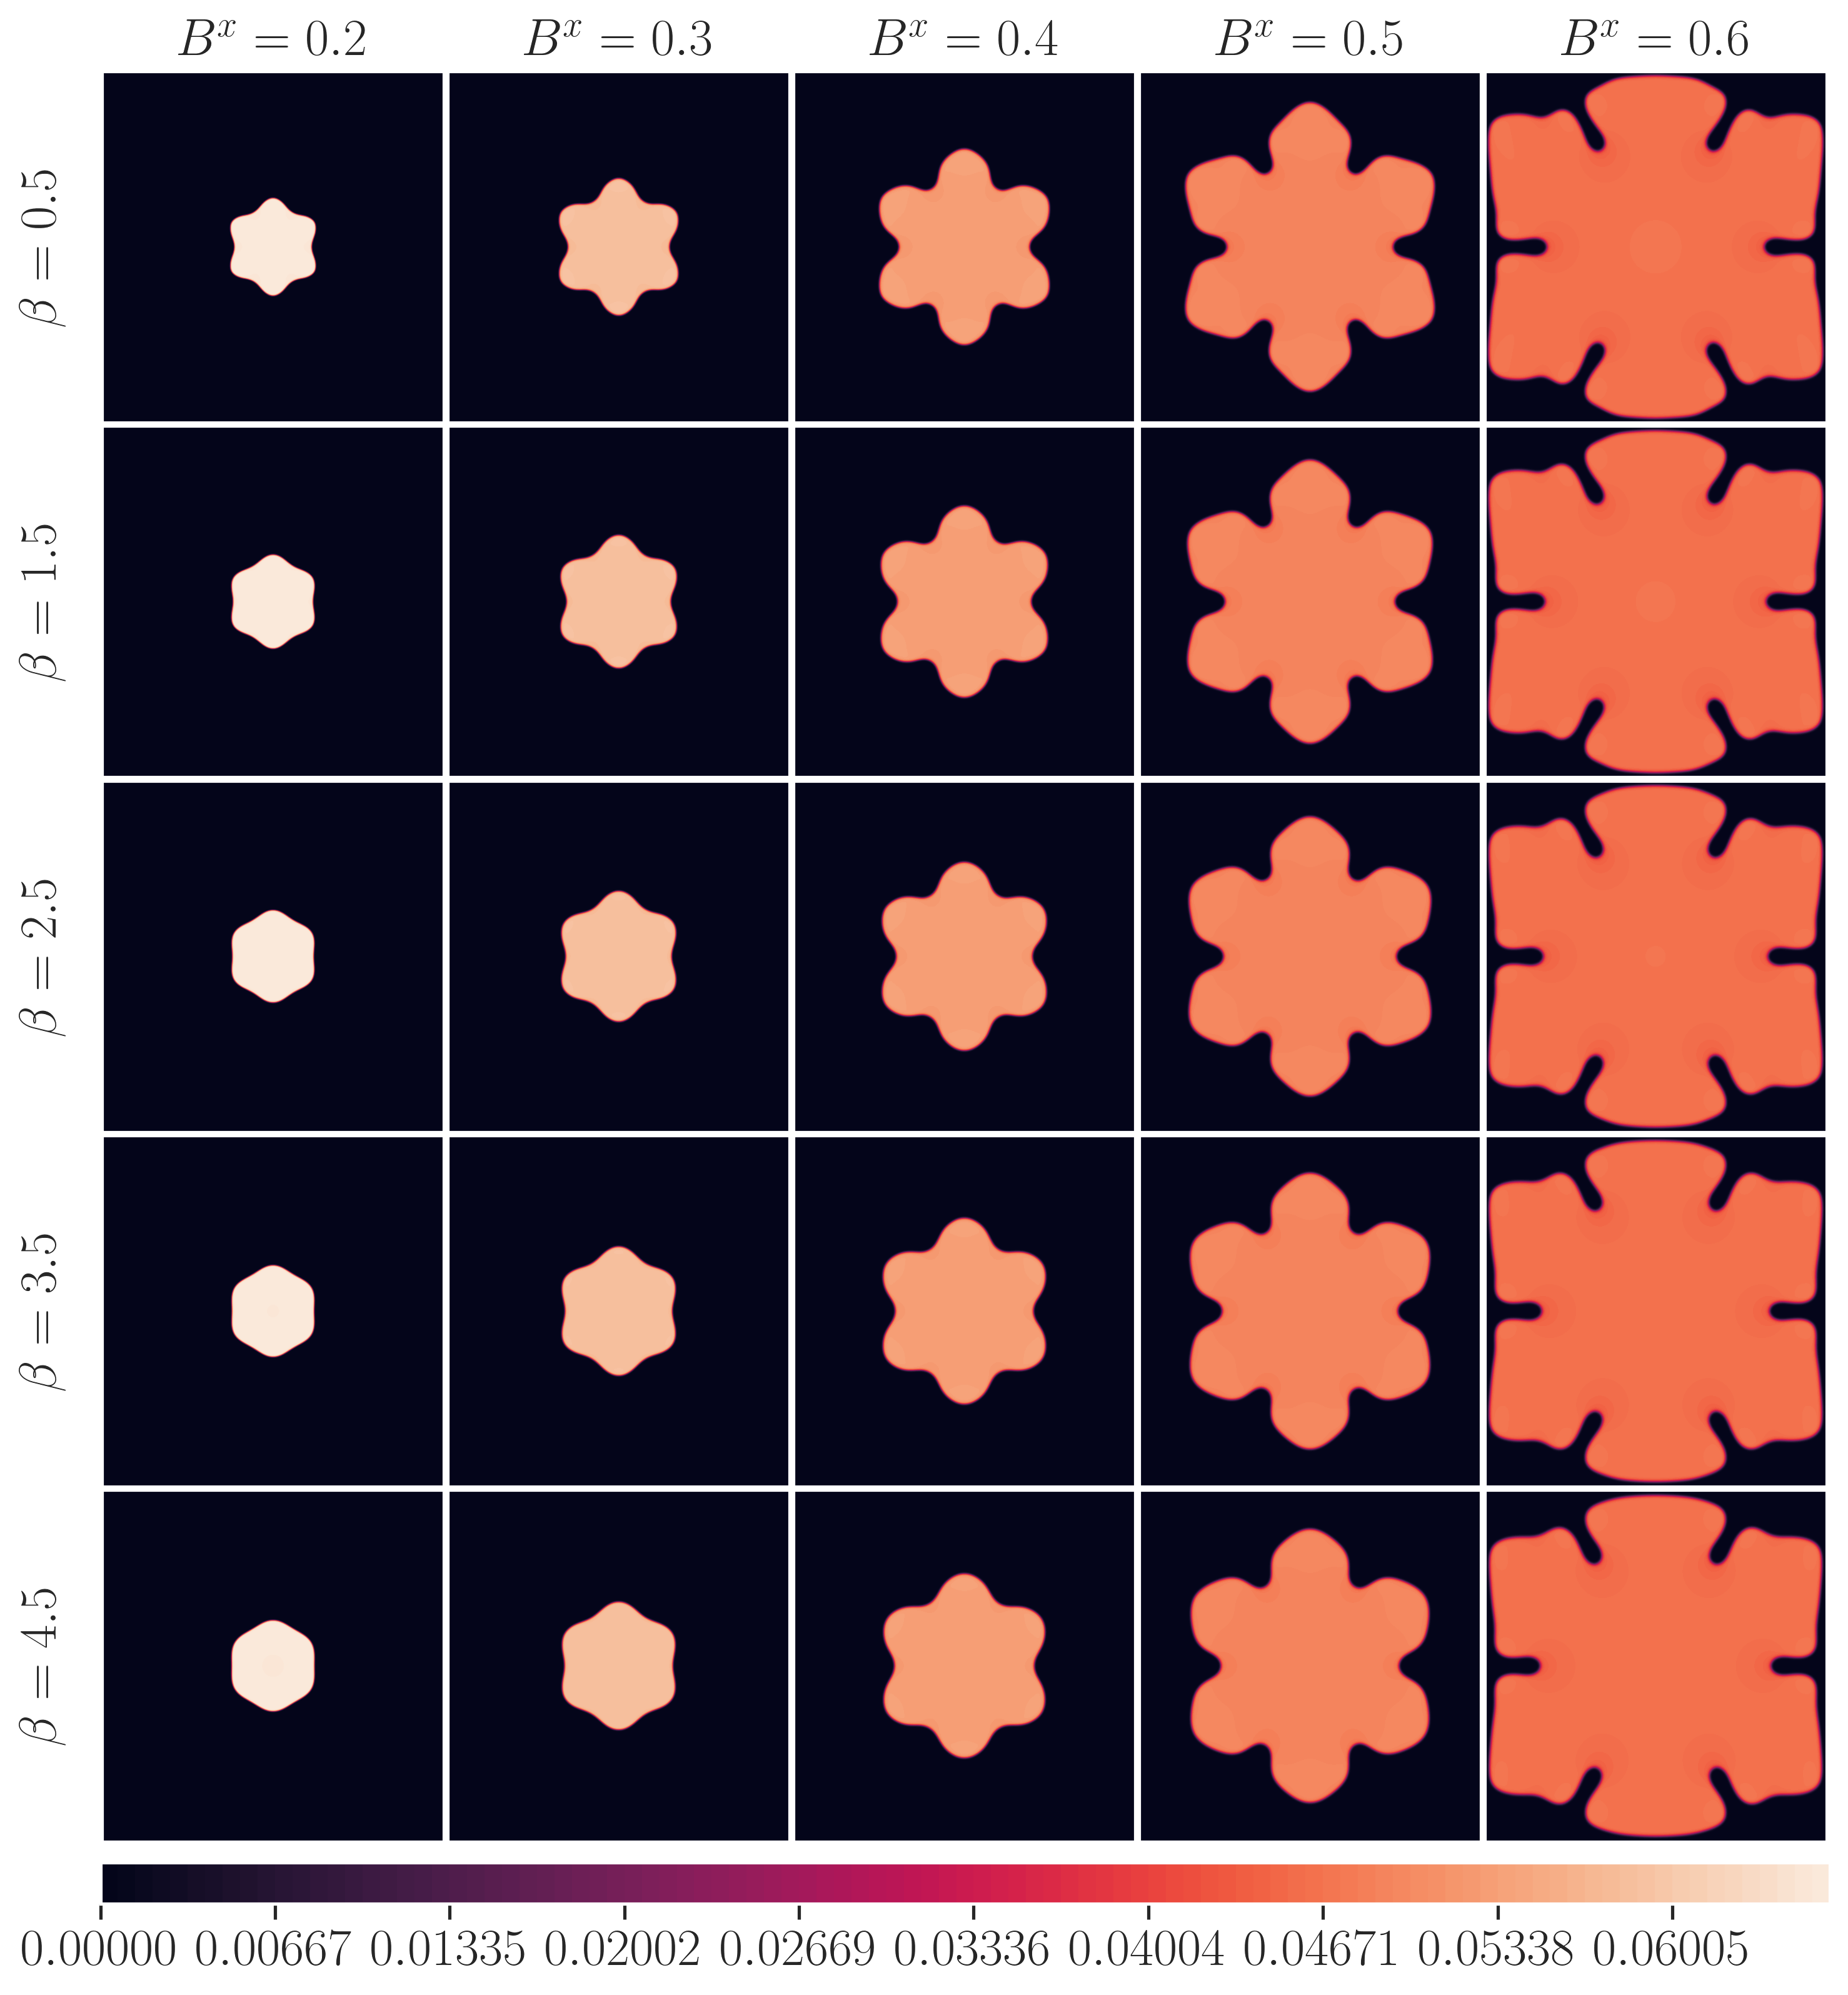

In [71]:
sim_paths = np.array(sim_paths)
x_labels = np.array(x_labels)
y_labels = np.array(y_labels)

### Check all ###

are_labels_ok = x_labels.shape[0] == sim_paths.shape[1]
are_labels_ok = are_labels_ok and y_labels.shape[0] == sim_paths.shape[0]

if not are_labels_ok:
    print("ERROR: check if dimensions of paths and labels are fine.")

### Get Max min ###

arr_to_plot = []
xms = []
yms = []
max_val = -1e6
min_val = 1e6

for row_i in range(sim_paths.shape[0]):
    for col_i in range(sim_paths.shape[1]):

        sim_path = sim_paths[row_i, col_i]
        config = utils.get_config(sim_path)

        if use_n0:

            n0 = rw.read_arr_at_line(
                f"{sim_path}/eta_files/0.0000/n0.txt",
                plot_i,
                config["numPtsX"],
                config["numPtsY"]
            )

            arr_to_plot.append(n0)

        else:

            etas = rw.read_all_etas_at_line(
                f"{sim_path}/eta_files/0.0000",
                plot_i,
                config["numPtsX"],
                config["numPtsY"],
                len(config["G"])
            )

            eta_sum = np.zeros(etas[0].shape, dtype=complex)
            for eta_i in range(etas.shape[0]):
                eta_sum += etas[eta_i] * np.conj(etas[eta_i])
            eta_sum = np.real(eta_sum)

            arr_to_plot.append(eta_sum)

        max_val = np.max([max_val, np.max(arr_to_plot[-1])])
        min_val = np.min([min_val, np.min(arr_to_plot[-1])])

### Create axis ###

cbar_levels = np.linspace(min_val, max_val, cbar_color_amount)

fig = plt.figure(figsize=figsize)
axs = []

for row_i in range(sim_paths.shape[0]):
    for col_i in range(sim_paths.shape[1]):

        i = col_i + row_i * sim_paths.shape[1]

        ax = plt.subplot2grid(
            sim_paths.shape, (row_i, col_i), fig=fig
        )
        if set_aspect_equal:
            ax.set_aspect("equal")
        axs.append(ax)

        sim_path = sim_paths[row_i, col_i]
        config = utils.get_config(sim_path)

        x = np.linspace(-config["xlim"], config["xlim"], config["numPtsX"])
        y = np.linspace(-config["xlim"], config["xlim"], config["numPtsY"])

        xm, ym = np.meshgrid(x, y)

        if use_global_min_max:
            cont = ax.contourf(xm, ym, arr_to_plot[i], levels=cbar_levels)
        else:
            cont = ax.contourf(xm, ym, arr_to_plot[i], cbar_color_amount)

        ax.set_xticklabels([])
        ax.set_yticklabels([])

        if row_i == 0:
            ax.set_title(x_labels[col_i], fontdict={"fontsize": fontsize})
        else:
            # this has to be here since plot funcs create title
            ax.set_title(None) 

        if col_i == 0:
            ax.set_ylabel(
                y_labels[row_i], rotation=ylabel_rotation, fontsize=fontsize
            )

plt.tight_layout()

if show_cbar:
    fig.subplots_adjust(
        bottom=fig_adjust_bottom, 
        wspace=fig_adjust_wspace, 
        hspace=fig_adjust_hspace
    )
    cbar_ax = fig.add_axes(cbar_axes_pos)
    cbar = fig.colorbar(cont, cax=cbar_ax, orientation="horizontal")
    cbar.ax.tick_params(labelsize=fontsize)

plt.show()